# Credit Card Fraud Detection Project 

### ADASYN and SMOTE oversampling techniques, Decision Trees and LightGBM, SHAP values

## Introduction

This project aims to address the issue of fraud detection in credit card transactions. I explored the effectiveness of different oversampling techniques, (ADASYN and SMOTE), combined with Decision Trees and LightGBM models. Additionally, I examine the interpretability of these models using decision tree plots, feature importances and SHAP (SHapley Additive exPlanations) values. 

## Dataset Information

The dataset contains transactions made by European cardholders in September 2013. It consists of transactions that occurred over two days, with a total of 284,807 transactions, out of which only 492 are fraudulent. Consequently, the dataset is highly unbalanced, with frauds accounting for only 0.172% of all transactions, which needs to be accounted.

The dataset consists of numerical input variables resulting from a Principal Component Analysis (PCA) transformation. The PCA-transformed features are labeled as V1, V2, (...), V28, while the 'Time' and 'Amount' features are not transformed. The 'Time' feature represents the seconds elapsed between each transaction and the first transaction in the dataset, while the 'Amount' feature denotes the transaction amount.

The response variable, 'Class', takes a value of 1 in case of fraud and 0 otherwise.

Dataset can be accessed here: [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data).


In [6]:
#Import neccessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.tree import plot_tree
import shap

import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(42)
#Read in the dataset
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.drop(columns='Time', axis=1, inplace=True)

#Set color palette
sns.set_palette('seismic')
%matplotlib inline

In [7]:
#Look at the dataset summary and drop any duplicated rows
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())
print(df.median())
df.drop_duplicates(inplace=True)

(284807, 30)
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Clas

## Exploratory Data Analysis

As mentioned previously, the dataset contains very few fradulent transactions, which poses a challange, as the dataset is highly unbalanced.

Class
0    275190
1       473
Name: count, dtype: int64


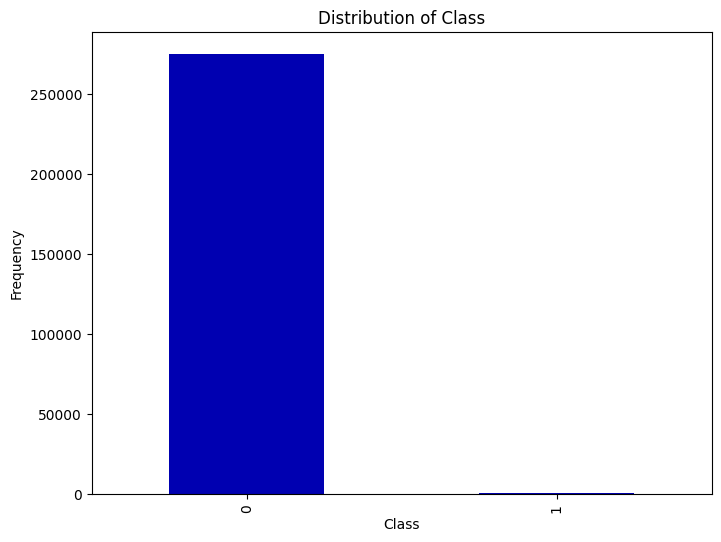

In [8]:
print(df['Class'].value_counts())
plt.figure(figsize=(8, 6))
df['Class'].value_counts().plot(kind='bar')
plt.title('Distribution of Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### Distributions of features

In [9]:
# Function for plotting histograms of numerical columns in a DataFrame
def plot_hist(df, color='navy'):
    '''
    Plot Histogram for Numerical Features in a DataFrame
    
    Filters numerical columns from the provided DataFrame and plots their histograms for exploratory data analysis.
    
    '''
    # Select numerical columns from the DataFrame
    num_columns = df.select_dtypes(include='number').columns
    
    # Check if there are any numerical columns
    if len(num_columns) == 0:
        print("No numerical columns found in the DataFrame.")
        return
    
    # Calculate the number of rows needed for subplots
    number_columns = len(num_columns)
    number_rows = (number_columns + 1) // 2
    
    # Create subplots
    fig, axes = plt.subplots(number_rows, 2, figsize=(12, 6*number_rows))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.5)
    
    # Loop through numerical columns and plot histogram
    for i, col in enumerate(num_columns):
        ax = axes[i]
        sns.histplot(data=df, x=col, color=color, ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(None)
        ax.set_ylabel('Count')
    
    # Remove excess subplot if the number of columns is odd
    if number_columns % 2 != 0:
        fig.delaxes(axes[-1])

    plt.show()


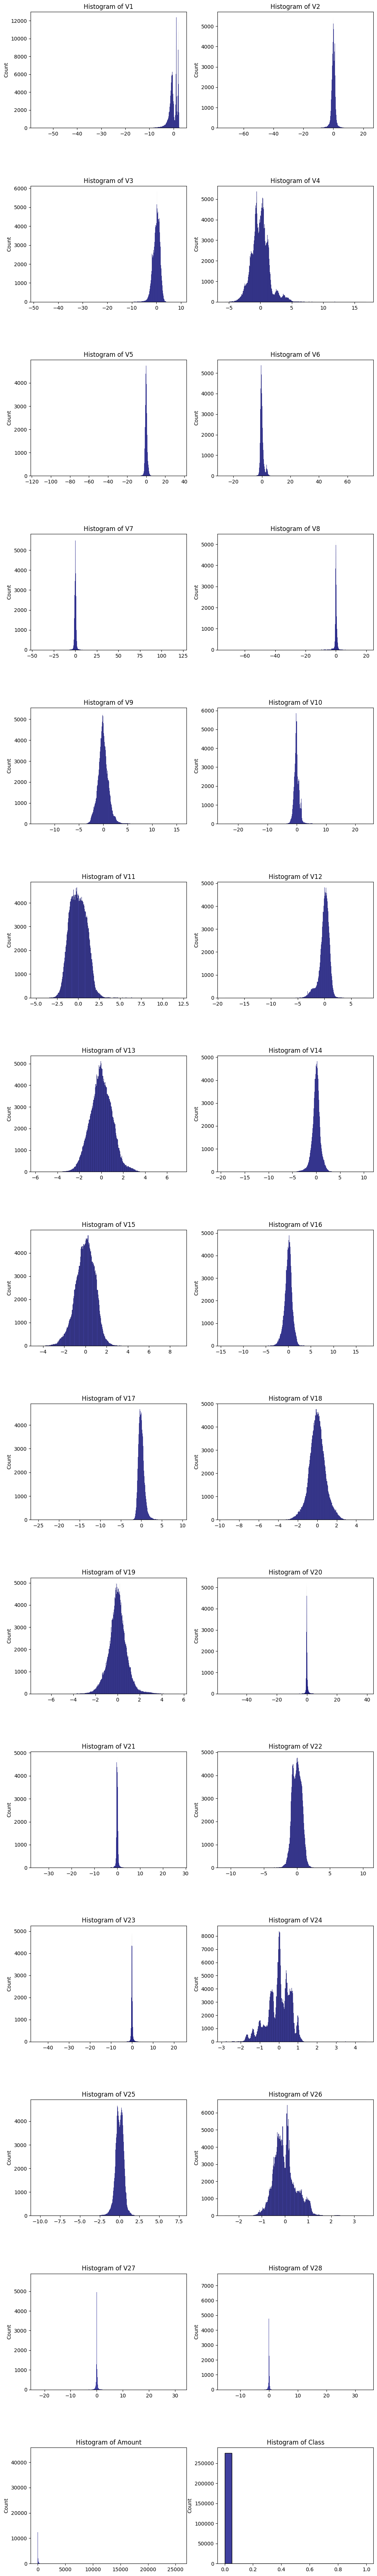

In [10]:
plot_hist(df)

In [102]:
# Calculate the IQR of columns
for column in df.columns:
    print(f"Checking {column}...")
    print()
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    print(f"IQR: {iqr}")

    # Identify lower outliers 
    lower_outliers = df[df[column] < q1 - 1.5 * iqr]
    upper_outliers = df[df[column] > q3 + 1.5 * iqr]

    # Calculate the number of lower outliers and upper outliers
    num_lower_outliers = len(lower_outliers)
    num_upper_outliers = len(upper_outliers)
    num_total_outliers = num_lower_outliers + num_upper_outliers
    print(f"Number of lower outliers: {num_lower_outliers}")
    print(f"Number of upper outliers: {num_upper_outliers}")
    print(f"Total number of outliers: {num_total_outliers}")

    # Calculate proportion of outliers in the dataset
    proportion_outliers = num_total_outliers / len(df) * 100
    print(f"Proportion of outliers in the dataset: {proportion_outliers:.2f}%")
    print()


Checking V1...

IQR: 2.235576089387179
Number of lower outliers: 6828
Number of upper outliers: 0
Total number of outliers: 6828
Proportion of outliers in the dataset: 2.48%

Checking V2...

IQR: 1.4331069267094398
Number of lower outliers: 8083
Number of upper outliers: 4730
Total number of outliers: 12813
Proportion of outliers in the dataset: 4.65%

Checking V3...

IQR: 1.8916294423075595
Number of lower outliers: 3412
Number of upper outliers: 22
Total number of outliers: 3434
Proportion of outliers in the dataset: 1.25%

Checking V4...

IQR: 1.6167901951909576
Number of lower outliers: 1992
Number of upper outliers: 8482
Total number of outliers: 10474
Proportion of outliers in the dataset: 3.80%

Checking V5...

IQR: 1.3047129254230199
Number of lower outliers: 3752
Number of upper outliers: 7826
Total number of outliers: 11578
Proportion of outliers in the dataset: 4.20%

Checking V6...

IQR: 1.1535646473551968
Number of lower outliers: 1784
Number of upper outliers: 19253
Total

After analyzing the outliers identified through the IQR method, it's evident that certain columns exhibit a notable number of outliers. It's essential to consider these outliers when deciding on transformations for the data.

In [103]:
# Check skew of the features
df.skew().sort_values(ascending=False)

Class     24.079142
Amount    16.841622
V28       11.400938
V7         2.877722
V21        2.784302
V6         1.867576
V10        1.242165
V4         0.681387
V26        0.587603
V9         0.550965
V11        0.347772
V19        0.115957
V13        0.061058
V22       -0.200868
V18       -0.255710
V15       -0.295836
V25       -0.408260
V24       -0.545636
V27       -0.745732
V16       -1.048371
V14       -1.953613
V20       -2.045060
V12       -2.208171
V3        -2.216730
V5        -2.458790
V1        -3.273070
V17       -3.802987
V2        -4.653486
V23       -5.805236
V8        -8.292631
dtype: float64

In [104]:
# Check correlations with target variable
correlations = df.corr()
class_correlations = correlations['Class'].sort_values(ascending=False)
print(class_correlations)

Class     1.000000
V11       0.151260
V4        0.130313
V2        0.084754
V19       0.033784
V8        0.033364
V21       0.026239
V27       0.021888
V20       0.021349
V28       0.009642
Amount    0.005451
V22       0.004612
V26       0.004341
V25       0.003593
V15      -0.002824
V13      -0.003934
V23      -0.006206
V24      -0.006831
V6       -0.044777
V5       -0.088642
V9       -0.094583
V1       -0.094718
V18      -0.106447
V7       -0.173292
V3       -0.185772
V16      -0.188222
V10      -0.208104
V12      -0.253150
V14      -0.297550
V17      -0.317202
Name: Class, dtype: float64


## SMOTE and ADASYN oversampling

In order to mitigate the imbalance in the dataset, two oversampling techniques were employed:

- **SMOTE (Synthetic Minority Over-sampling Technique)** generates synthetic samples for the minority class by interpolating between existing minority class samples, balancing class distribution.
- **ADASYN (Adaptive Synthetic Sampling)** is an extension of SMOTE that applies higher sampling intensity to minority class instances that are more difficult to learn, adapting to the dataset's complexity.

We will assess the performance of each technique to determine its effectiveness for this specific task.

In [105]:
# Split into train and test sets
X = df.drop('Class', axis=1)  
y = df['Class'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify= y, shuffle=True)

In [106]:
# Use SMOTE and ADASYN oversampling on training set
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

print(y_smote.value_counts())
print(y_adasyn.value_counts())

Class
0    192633
1    192633
Name: count, dtype: int64
Class
1    192657
0    192633
Name: count, dtype: int64


## Model selection

For both training sets, model selection with 5-fold cross-validation was employed. Candidates included Logistic Regression, Decision Trees, and LightGBM. Decision Trees and LightGBM exhibited similar performance, with Logistic Regression slightly lagging behind.

Decision Trees and LightGBM were selected for further tuning.

In [107]:
# Function for model selection

def model_selection(models, scoring_metric, X_train=X_train, y_train=y_train, n_splits=5):
    '''
    This function performs model selection by evaluating the performance of different models using cross-validation.
    
    Parameters:
    - models (dict): A dictionary containing model names as keys and corresponding model instances as values.
    - scoring_metric (str): The evaluation metric to use for comparing models.
    - X_train (array-like): The feature matrix of the training data.
    - y_train (array-like): The target vector of the training data.
    
    Returns:
    - results (dict): A dictionary containing model names as keys and the corresponding cross-validation results as values.
    '''
    results = {}
    
    for model_name, model in models.items():
        kf = KFold(n_splits=n_splits, random_state=12, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring_metric)
        results[model_name] = cv_results

    plt.figure(figsize=(10, 6))
    plt.boxplot(results.values(), labels=results.keys())
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel(scoring_metric)
    plt.grid(True)
    plt.show()
    
    return results

In [108]:
# Define the models and scoring metric
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
}

scoring_metric = 'roc_auc'


[LightGBM] [Info] Number of positive: 154132, number of negative: 154080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 308212, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500084 -> initscore=0.000337
[LightGBM] [Info] Start training from score 0.000337
[LightGBM] [Info] Number of positive: 154074, number of negative: 154139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 308213, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499895 -> initscore=-0.000422
[LightGBM] [Info] Start training from score -0.000422
[LightGB

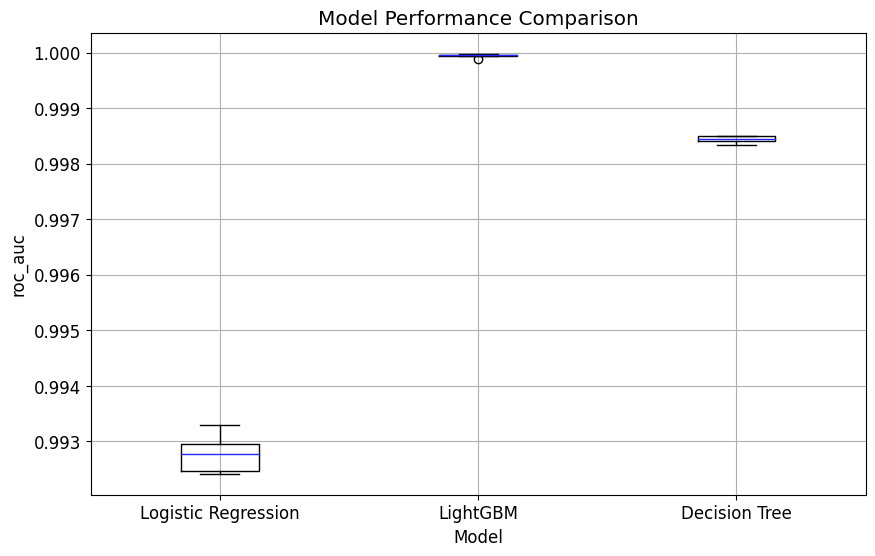

{'Logistic Regression': array([0.99277515, 0.99295551, 0.99241889, 0.99330245, 0.99247636]),
 'LightGBM': array([0.9999606 , 0.99998159, 0.99996377, 0.99993763, 0.99989242]),
 'Decision Tree': array([0.998495  , 0.99841608, 0.99849409, 0.99834013, 0.99845467])}

In [109]:
model_selection(models=models, scoring_metric=scoring_metric, X_train=X_smote, y_train=y_smote)

[LightGBM] [Info] Number of positive: 154098, number of negative: 154134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 308232, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499942 -> initscore=-0.000234
[LightGBM] [Info] Start training from score -0.000234
[LightGBM] [Info] Number of positive: 154171, number of negative: 154061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 308232, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500178 -> initscore=0.000714
[LightGBM] [Info] Start training from score 0.000714
[LightGB

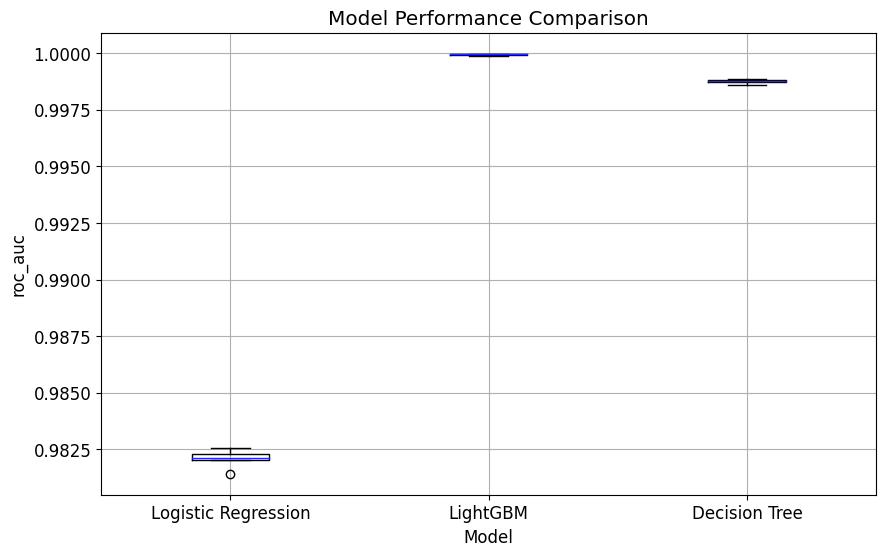

{'Logistic Regression': array([0.98142399, 0.98228056, 0.98203486, 0.9821187 , 0.98254507]),
 'LightGBM': array([0.99992295, 0.99997712, 0.99985824, 0.99996687, 0.99997214]),
 'Decision Tree': array([0.99876665, 0.9985993 , 0.99881796, 0.99884613, 0.99872752])}

In [110]:
model_selection(models=models, scoring_metric=scoring_metric, X_train=X_adasyn, y_train=y_adasyn)

## Hyperparameter Tuning and Model Training

Both Decision Tree Classifier and LightGBM Classifier were further tuned on both training sets. Quantile Transformer was used as a preprocessor to mitigate the skewed feature distributions.

In [111]:
# Define preprocessor and pipeline for LightGBM
preprocessor = ColumnTransformer(
    transformers=[
        ('quantile', QuantileTransformer(output_distribution='normal'), slice(0,None)),
    ],
    remainder='passthrough'
)

pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(verbosity=-1))  
])

lgb_param_grid = {
    'classifier__n_estimators': [400],  
    'classifier__max_depth': [10], 
    'classifier__min_child_samples': [20, 30],
    'classifier__learning_rate': [0.05],
    'classifier__colsample_bytree': [0.8, 0.9]
}

# Perform hyperparameter tuning for both sets
random_search_lgb = RandomizedSearchCV(pipeline_lgb, param_distributions=lgb_param_grid, n_iter=20, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)

best_models = {}

for X, y, sampler_name in zip([X_smote, X_adasyn], [y_smote, y_adasyn], ['SMOTE', 'ADASYN']):
    random_search_lgb.fit(X, y)
    best_models[sampler_name] = {
        'best_params': random_search_lgb.best_params_,
        'best_estimator': random_search_lgb.best_estimator_
    }
    print(f"Best Hyperparameters for {sampler_name}: {random_search_lgb.best_params_}")
    print()

best_model_smote_lgb = best_models['SMOTE']['best_estimator']
best_model_adasyn_lgb = best_models['ADASYN']['best_estimator']


Best Hyperparameters for SMOTE: {'classifier__n_estimators': 400, 'classifier__min_child_samples': 30, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.9}

Best Hyperparameters for ADASYN: {'classifier__n_estimators': 400, 'classifier__min_child_samples': 20, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8}



In [112]:
# Define preprocessor and pipeline for DT

pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())  
])

dt_param_grid = {
    'classifier__max_depth': [10], 
    'classifier__min_samples_split': [20, 30],
    'classifier__min_samples_leaf': [5, 10]
}

# Perform hyperparameter tuning for both sets
random_search_dt = RandomizedSearchCV(pipeline_dt, param_distributions=dt_param_grid, n_iter=30, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)

best_models_dt = {}

for X, y, sampler_name in zip([X_smote, X_adasyn], [y_smote, y_adasyn], ['SMOTE', 'ADASYN']):
    random_search_dt.fit(X, y)
    best_models_dt[sampler_name] = {
        'best_params': random_search_dt.best_params_,
        'best_estimator': random_search_dt.best_estimator_
    }
    print(f"Best Hyperparameters for {sampler_name}: {random_search_dt.best_params_}")
    print()
    
best_model_smote_dt = best_models['SMOTE']['best_estimator']
best_model_adasyn_dt = best_models['ADASYN']['best_estimator']

Best Hyperparameters for SMOTE: {'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 10}

Best Hyperparameters for ADASYN: {'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 10}



## Model Evaluation

Upon training and tuning, all four models were evaluated. Both SMOTE and ADASYN training sets exhibited similar performance. However in the end, SMOTE demonstrated slightly superior performance in critical metrics - TPR and FNR, as well precision and recall for the positive class (our 'fraud')

It is impotrant to note however, that with different hyperparameters during training, there were instances when ADASYN set performed slightly better, so the diffrence is not that notable.

Interestingly, both LightGBM and Decision Trees performed very similarly in this task.

In [113]:
# Evaluate all four models
models = {
    'LGBM (SMOTE)': best_model_smote_lgb,
    'LGBM (ADASYN)': best_model_adasyn_lgb,
    'Decision Tree (SMOTE)': best_model_smote_dt,
    'Decision Tree (ADASYN)': best_model_adasyn_dt
}

for model_name, model in models.items():
    
    y_pred = model.predict(X_test)
    
    # Classification Report
    print(f"Classification report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # ROC AUC score
    print(f"ROC AUC for {model_name}:")
    print(roc_auc_score(y_test, y_pred))
    
    # TPR and FNR
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()
    TPR = TP / (TP + FN)
    FNR = FN / (TP + FN)
    print(f"True Positive Rate for {model_name}:", TPR)
    print(f"False Negative Rate for {model_name}:", FNR)
    print()
    print()


Classification report for LGBM (SMOTE):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82557
           1       0.78      0.82      0.80       142

    accuracy                           1.00     82699
   macro avg       0.89      0.91      0.90     82699
weighted avg       1.00      1.00      1.00     82699

ROC AUC for LGBM (SMOTE):
0.9082508423117652
True Positive Rate for LGBM (SMOTE): 0.8169014084507042
False Negative Rate for LGBM (SMOTE): 0.18309859154929578


Classification report for LGBM (ADASYN):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82557
           1       0.76      0.80      0.78       142

    accuracy                           1.00     82699
   macro avg       0.88      0.90      0.89     82699
weighted avg       1.00      1.00      1.00     82699

ROC AUC for LGBM (ADASYN):
0.9011904195257668
True Positive Rate for LGBM (ADASYN): 0.8028169014084507
F

## Model Interpretation - Decision Tree plots, Feature Importances, SHAP values

Let's look at tree plots, feature importances and a summary plot of SHAP values to further understand which features proved to be crucial for the models.

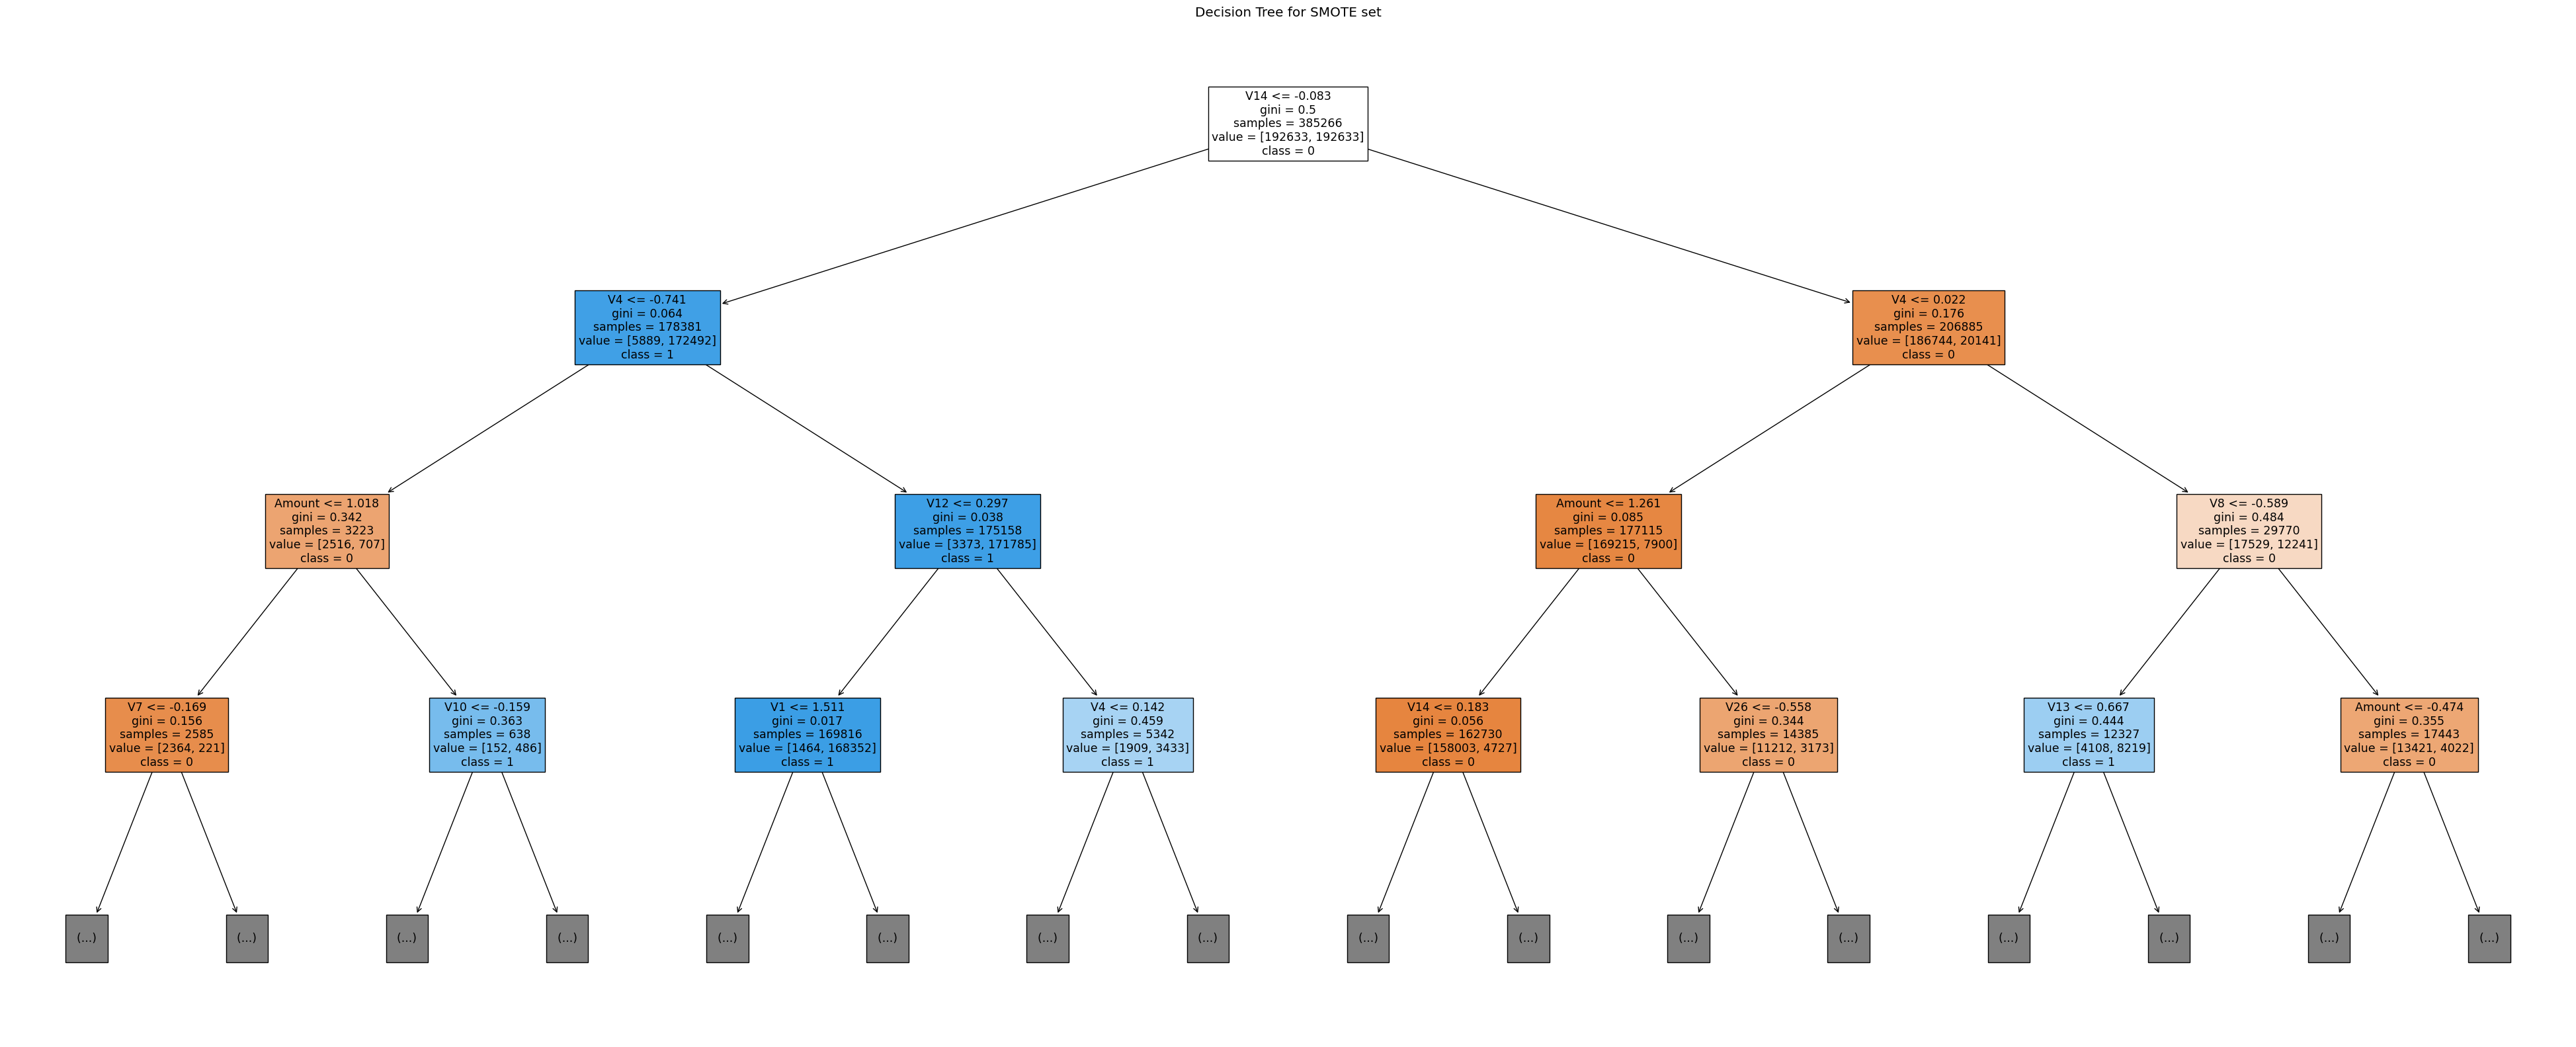

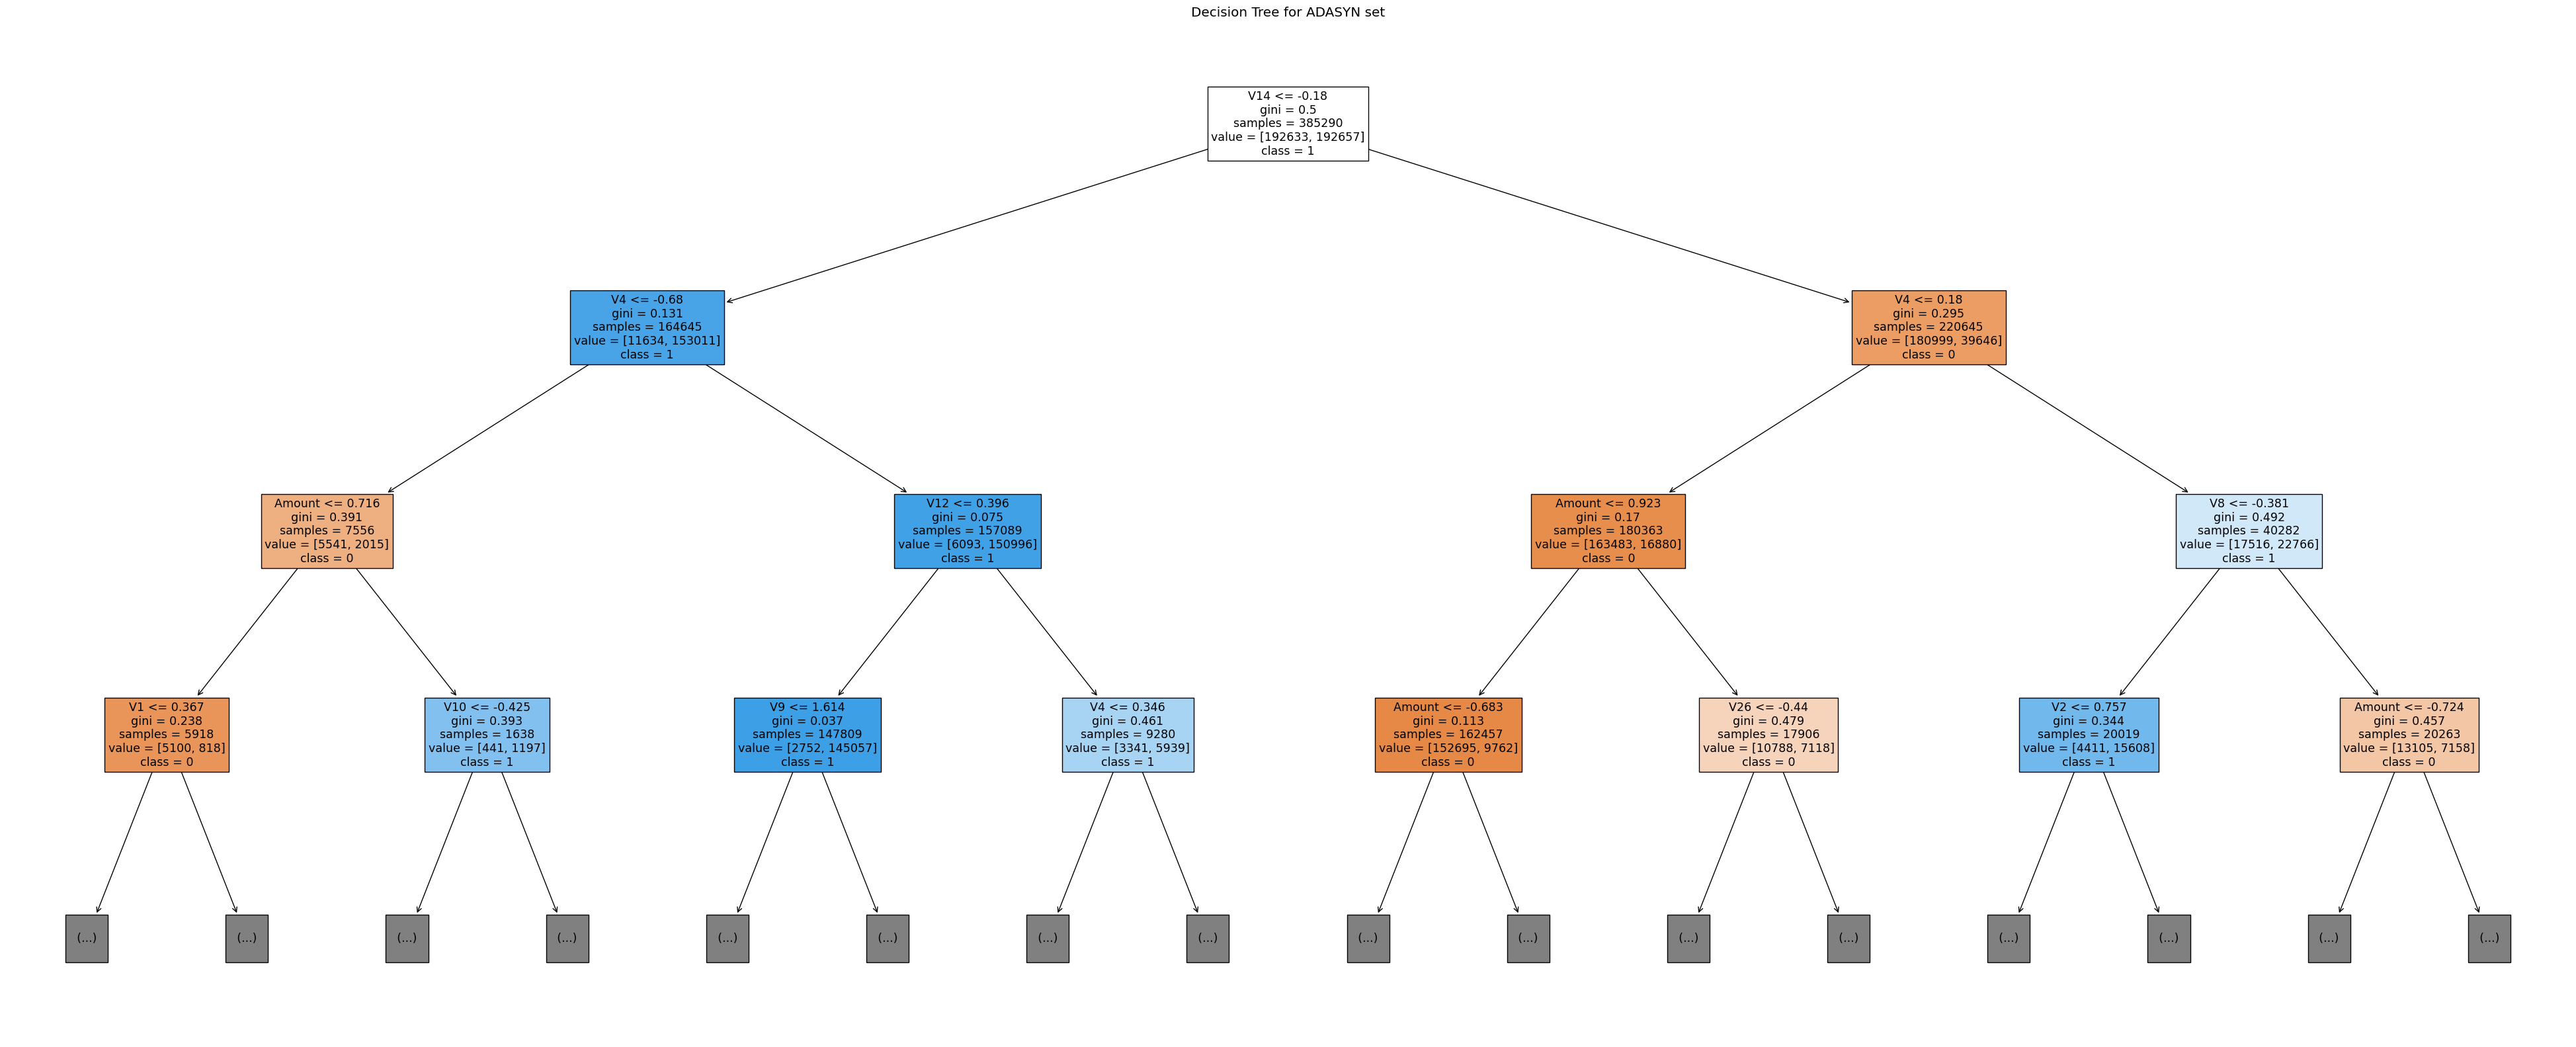

In [114]:
# Plot Decision Trees
for sampler_name, best_model_info in best_models_dt.items():
    best_estimator = best_model_info['best_estimator']
    classifier = best_estimator.named_steps['classifier']  

    if isinstance(classifier, DecisionTreeClassifier):
        plt.figure(figsize=(50, 20))
        plot_tree(classifier, feature_names=feature_names, class_names=class_names, filled=True, max_depth=3)
        plt.title(f'Decision Tree for {sampler_name} set')
        plt.show()
    else:
        print(f"The classifier for {sampler_name} is not a Decision Tree Classifier.")

Upon looking at the first three layers of the tree plots, we observe that V14 has a position as the root node and is the most crucial feature in the decision-making process for both models. Furthermore, features such as V4, Amount, and V12 are close to the root node across these layers, suggesting their importance in the decision paths of the tree.

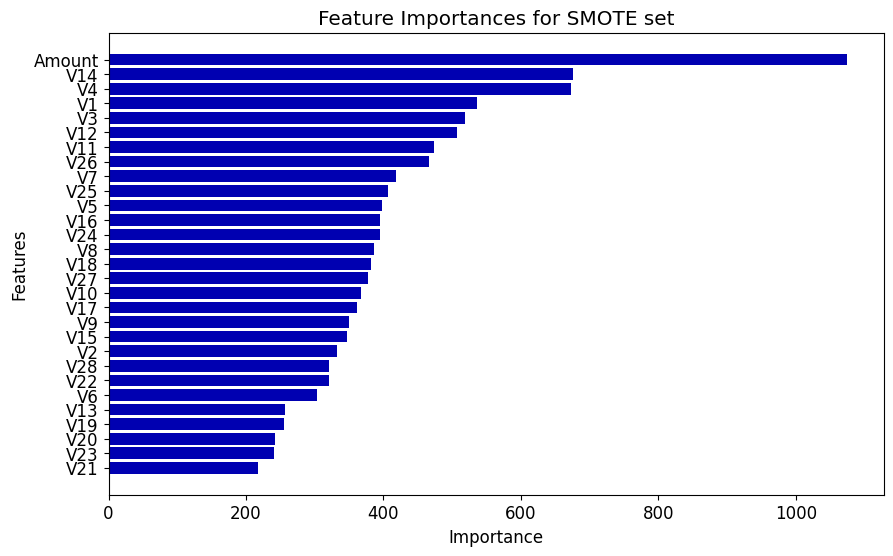

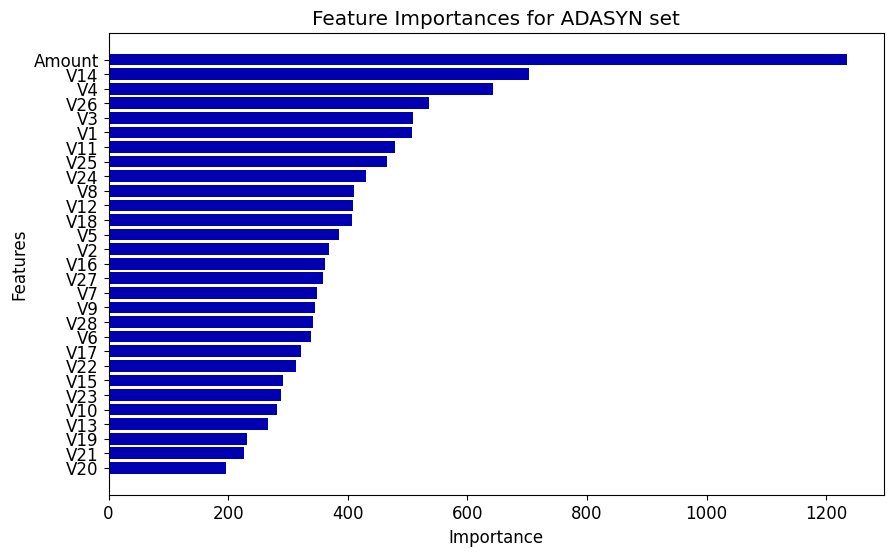

In [115]:
# Plot feature importances for SMOTE and ADASYN for LGBM

sorted_indices_smote = np.argsort(feature_importance_smote)
sorted_indices_adasyn = np.argsort(feature_importance_adasyn)

sorted_feature_names_smote = np.array(feature_names)[sorted_indices_smote]
sorted_feature_importance_smote = feature_importance_smote[sorted_indices_smote]

sorted_feature_names_adasyn = np.array(feature_names)[sorted_indices_adasyn]
sorted_feature_importance_adasyn = feature_importance_adasyn[sorted_indices_adasyn]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names_smote, sorted_feature_importance_smote)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances for SMOTE set')
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names_adasyn, sorted_feature_importance_adasyn)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances for ADASYN set')
plt.show()

The feature importance plots for LightGBM models suggest that Amount had by far biggest importance for both training sets, followed by V14 and V4 consistently. After that, there are slight differences between the two LGBM models. Let us also look at SHAP values summary plot for the SMOTE and ADASYN datasets.

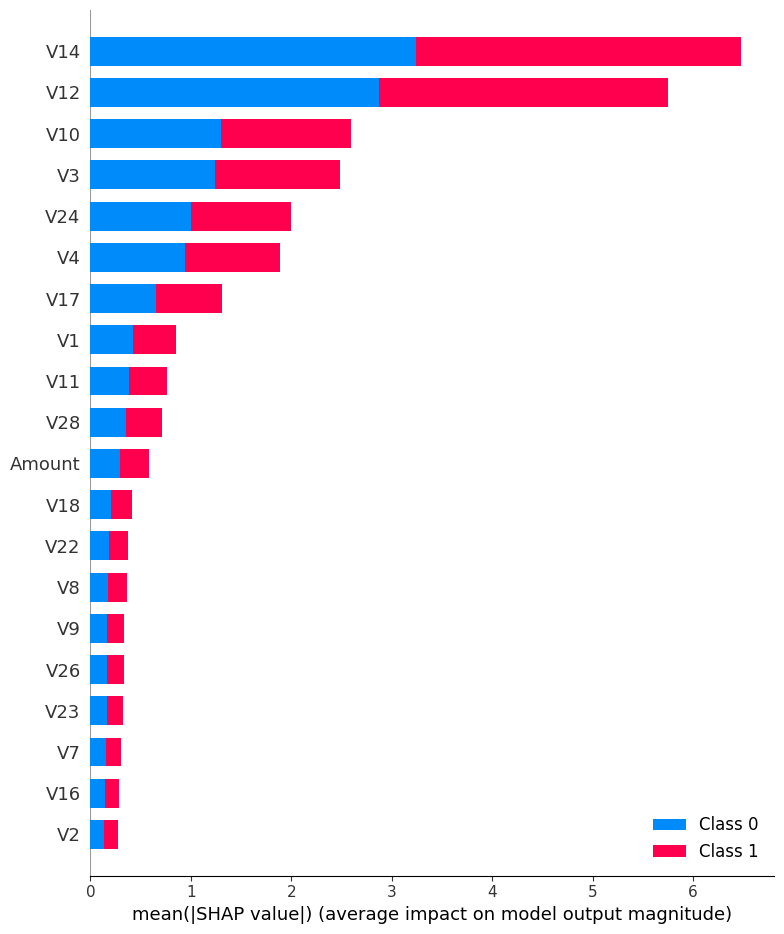

In [116]:
# Compute SHAP values for the SMOTE training set and plot summary plot
shap.initjs()
quant = QuantileTransformer(output_distribution='normal')
X_smote_transformed = quant.fit_transform(X_smote)
X_test_transformed = quant.transform(X_test)

lgb = LGBMClassifier(min_samples_split=20, min_samples_leaf=5, max_depth=10, random_state=42, verbosity=-1)
lgb.fit(X_smote_transformed, y_smote)

explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, feature_names=X_test.columns)

As expected, the SHAP values are quite different from the feature importances, which stems from differences between those metrics. Hee, the mean SHAP value for Amount is notably lower compared to its prominent position in the feature importances plot. Instead, features like V10 and V14 exhibit the highest impact on the model output, followed by V1 and V4.

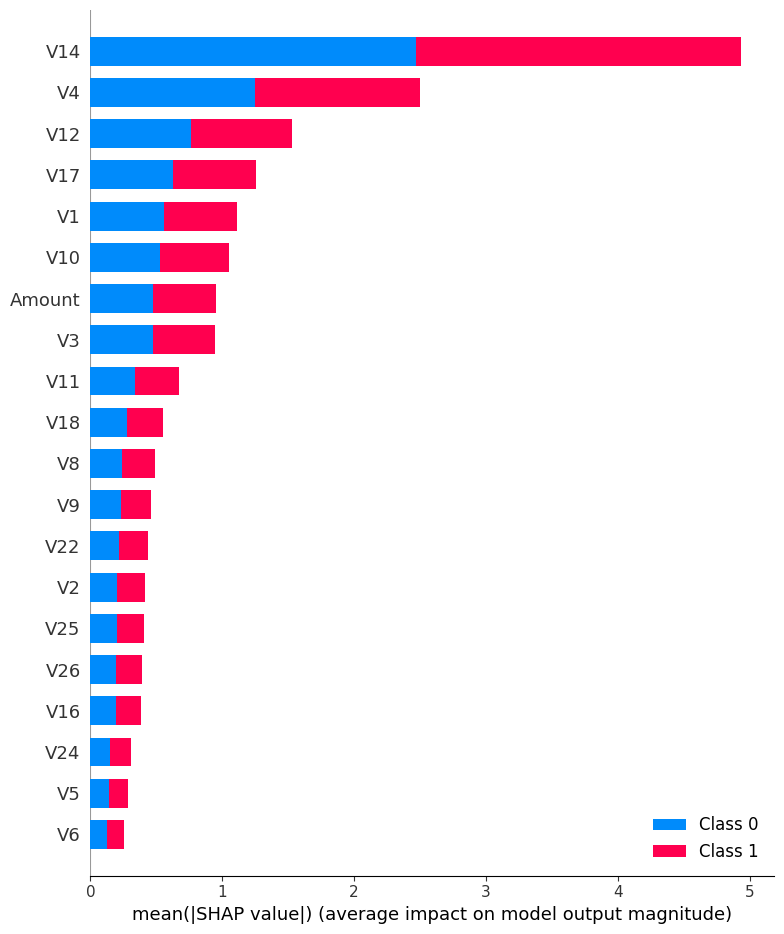

In [117]:
# SHAP summary plot for ADASYN set
X_adasyn_transformed = quant.fit_transform(X_adasyn)
X_test_transformed = quant.transform(X_test)

lgb2 = LGBMClassifier(min_samples_split=20, min_samples_leaf=5, max_depth=10, random_state=42, verbosity=-1)
lgb2.fit(X_adasyn_transformed, y_adasyn)

explainer = shap.TreeExplainer(lgb2)
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, feature_names=X_test.columns)

The second model made with ADASYN training set, however it has very similar performance, it has also quite different SHAP values. For instance, while V14 remains a significant feature (ranking first in importance), V10 is ranked sixth. This observation underscores that while there are similarities in feature importance across various models, we can see quite distinct differences too.
